In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
encodings_to_try = ['utf-8', 'ISO-8859-1', 'latin1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("SeoulBikeData.csv", encoding=encoding)
        df = df.drop(["Date", "Holiday", "Seasons"], axis=1)
        print(f"Successfully read the CSV file with encoding: {encoding}")
        break  # Break out of the loop if successful
    except UnicodeDecodeError:
        print(f"Failed to read with encoding: {encoding}")

Failed to read with encoding: utf-8
Successfully read the CSV file with encoding: ISO-8859-1


In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"]=="Yes").astype(int)
df= df[df["hour"]==12]
df= df.drop(["hour"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [ ]:
df=df.drop(["wind", "visibility", "functional"], axis=1)

In [ ]:
df.head()

#Train/Valid/Test dataset

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
def get_xy(dataframe, y_label, x_label=None):
  dataframe = copy.deepcopy(dataframe)
  if x_label is None:
    x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_label) ==1:
        x=dataframe[x_label[0]].values.reshape(-1,1)
    else:
        x= dataframe[x_label].values
    y= dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((x,y))
    return data, x, y

In [ ]:
_,x_train_temp, y_train_temp = get_xy(train, "bike_count", x_label=["temp"])
_,x_val_temp, y_val_temp = get_xy(val, "bike_count", x_label=["temp"])
_,x_test_temp, y_test_temp = get_xy(test, "bike_count", x_label=["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [ ]:
temp_reg.score(x_test_temp, y_test_temp)

0.38892137846064856

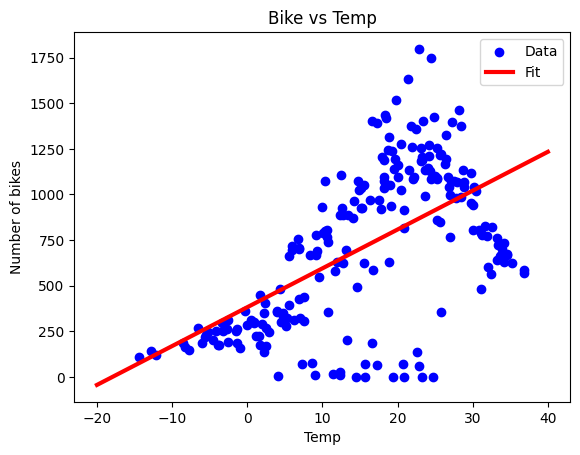

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#Multiple Linear Regression

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_,x_train_all, y_train_all = get_xy(train, "bike_count", x_label=df.columns[1:])
_,x_val_all, y_val_all = get_xy(val, "bike_count", x_label=df.columns[1:])
_,x_test_all, y_test_all = get_xy(test, "bike_count", x_label=df.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [ ]:
all_reg.score(x_test_all, y_test_all)

0.4862006698807705

#Regression with neural network

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()


In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history= temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    epochs=50,
    validation_data=(x_val_temp, y_val_temp))

Epoch 1/50
7/7 [==============================] - 1s 31ms/step - loss: 701111.0000 - val_loss: 646733.5000
Epoch 2/50
7/7 [==============================] - 0s 9ms/step - loss: 699759.8750 - val_loss: 645518.6875
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 698483.3125 - val_loss: 644301.7500
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 697130.0625 - val_loss: 643098.8125
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 695859.1875 - val_loss: 641880.5625
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 694496.3750 - val_loss: 640686.3750
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 693214.3750 - val_loss: 639479.5625
Epoch 8/50
7/7 [==============================] - 0s 10ms/step - loss: 691878.8125 - val_loss: 638285.8750
Epoch 9/50
7/7 [==============================] - 0s 11ms/step - loss: 690628.0000 - val_loss: 637065.6875
Epoch 10/50
7/7 [=========================

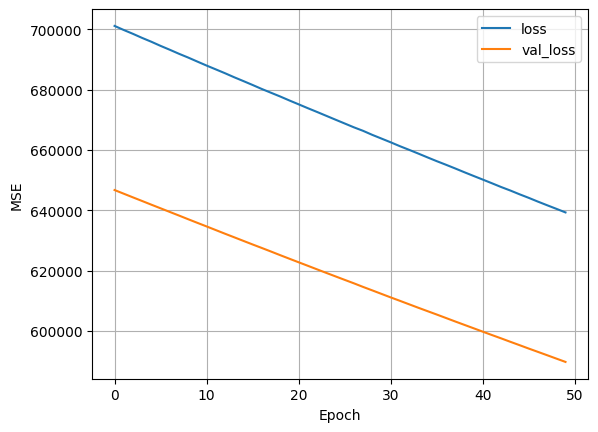

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


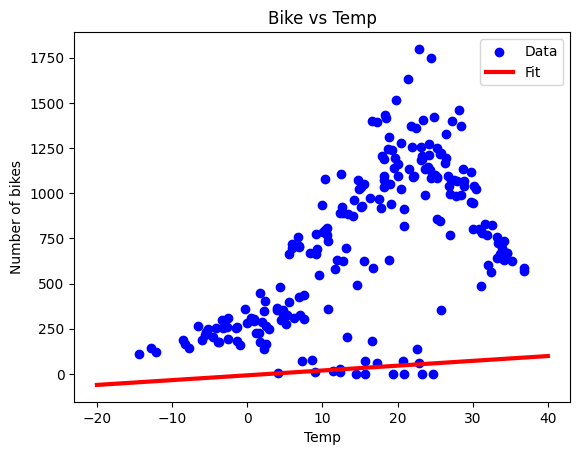

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#NN model

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
history= nn_model.fit(
    x_train_temp, y_train_temp,
    epochs=50,
    validation_data=(x_val_temp, y_val_temp))

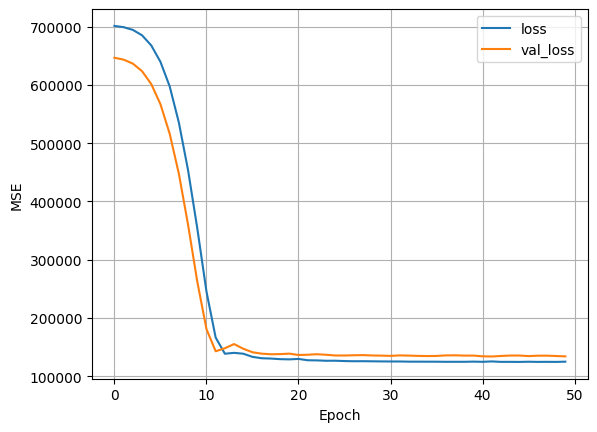

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 5ms/step


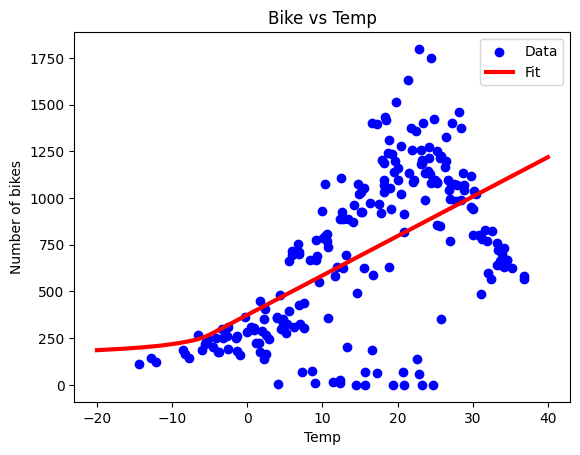

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)


In [ ]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
history= nn_model.fit(
    x_train_all, y_train_all,
    epochs=50,
    validation_data=(x_val_all, y_val_all))

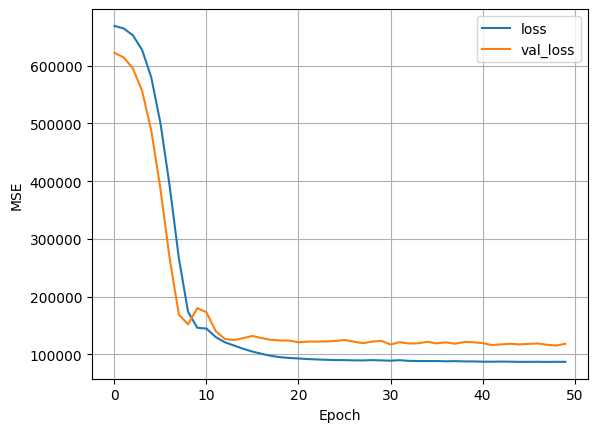

In [ ]:
plot_loss(history)

In [ ]:
#Calculate Mean Square error for both linear reg and nn

y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 5ms/step


In [ ]:
def MSE(y_pred, y_real):
  return(np.square(y_pred - y_real)).mean()

In [ ]:
MSE(y_pred_lr, y_test_all)

102845.58691955337

In [ ]:
MSE(y_pred_nn, y_test_all)

101395.25900436394

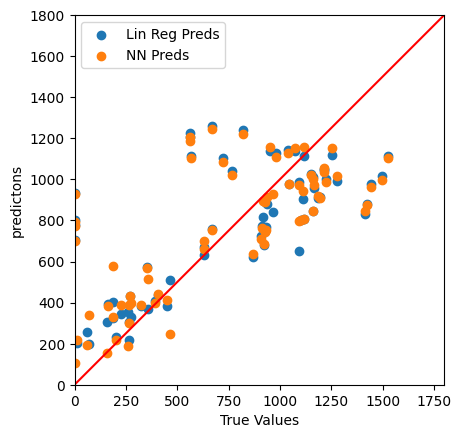

In [ ]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("predictons")
lims=[0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_=plt.plot(lims, lims, c="red")